In [83]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

In [84]:
# Let us create three datasets. The first is a toy one, the second consists
# of blobs of points, and the second consists of concentric circles.

blob = lambda x, y, stddev, n_samples: list(zip(
    np.random.normal(x, stddev, n_samples),
    np.random.normal(y, stddev, n_samples)
))

circle = lambda x, y, stddev, radius, n_samples: [
    (
        x + radius * math.cos(2 * math.pi * i / n_samples) + np.random.normal(0, stddev),
        y + radius * math.sin(2 * math.pi * i / n_samples) + np.random.normal(0, stddev)
    )
    for i in range(n_samples)
]

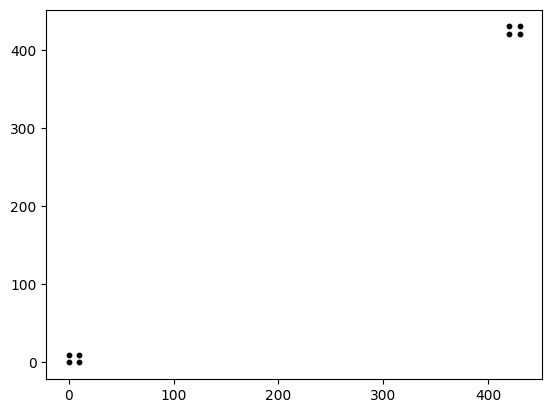

In [85]:
birthday_dataset = [(0, 0), (0, 10), (10, 0), (10, 10), (420, 420), (420, 430), (430, 420), (430, 430)]
plt.scatter(*zip(*birthday_dataset), s=10, color='black')
plt.show()

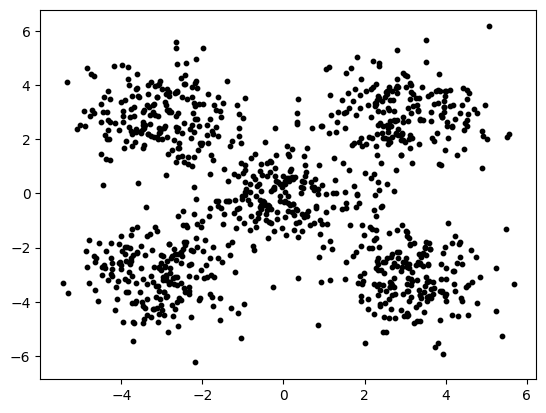

In [86]:
blobs_dataset = sum((blob(x, y, 1, 200) for x, y in [(0, 0), (3, 3), (-3, 3), (-3, -3), (3, -3)]), start=[])
plt.scatter(*zip(*blobs_dataset), s=10, color='black')
plt.show()

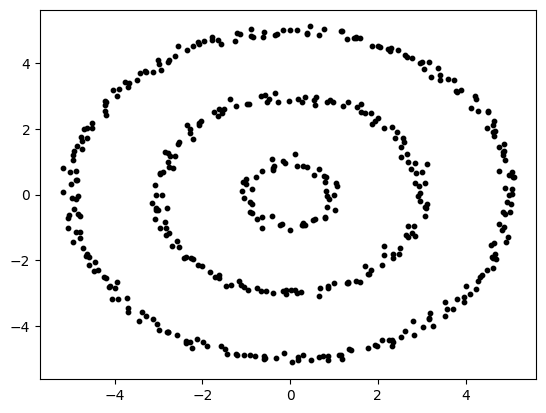

In [87]:
circles_dataset = sum((circle(0, 0, 0.1, radius, radius * 50) for radius in [1, 3, 5]), start=[])
plt.scatter(*zip(*circles_dataset), s=10, color='black')
plt.show()

In [104]:
def display_clusters(clusters):
    # get len(clusters) spaced out colors
    colors = plt.get_cmap('Accent')(np.linspace(0, 1, len(clusters)))
    for (cluster_center, cluster), color in zip(clusters.items(), colors):
        # plot the cluster center using a big marker
        plt.scatter(*cluster_center, s=1000, color=color, alpha=0.2)
        # plot the cluster points using small markers
        plt.scatter(*zip(*cluster), s=10, color=color)
    plt.show()

def compute_clusters(X, cluster_centers):
    '''
    Given fixed cluster centers, computes the clusters of each cluster center c
    with respect to X, i.e. the set of points whose nearest cluster center is c.
    
    Returns:
        clusters (dict): the clusters as sets of points (tuples of floats),
            keyed by their cluster center
    '''
    X, cluster_centers = np.array(X), np.array(cluster_centers)
    
    diff = X - np.repeat(cluster_centers[:,np.newaxis,:], len(X), axis=1)
    norms = np.linalg.norm(diff,axis=2)    
    mins = cluster_centers[np.argmin(norms,axis=0)]
    
    clusters = {}
        
    for center in cluster_centers:
        clusters[tuple(center)] = set()
    
    for x,cc in zip(X, mins):
        clusters[tuple(cc)].add(tuple(x))
                
    return clusters

{(110, 210): {(10, 10), (10, 0), (0, 10), (0, 0)}, (310, 210): {(430, 420), (420, 420), (430, 430), (420, 430)}}


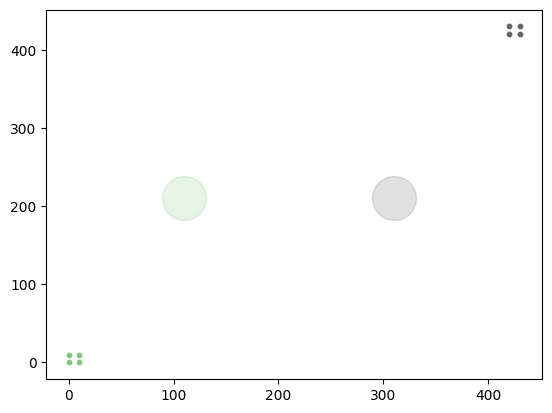

In [105]:
# The bottom-left points should be green, and the top-right points should be gray
print(compute_clusters(birthday_dataset, [(110, 210), (310, 210)]))
display_clusters(compute_clusters(birthday_dataset, [(110, 210), (310, 210)]))

In [106]:
# Here are some tests for `compute_clusters`
assert compute_clusters(birthday_dataset, [(5, 5), (425, 425)]) == {
    (5, 5): {(0, 0), (0, 10), (10, 0), (10, 10)},
    (425, 425): {(420, 420), (420, 430), (430, 420), (430, 430)}
}
assert compute_clusters(birthday_dataset, [(210, 210)]) == {
    (210, 210): set(birthday_dataset)
}
assert compute_clusters(birthday_dataset, birthday_dataset) == {
    point: {point}
    for point in birthday_dataset
}
assert compute_clusters(birthday_dataset, [(110, 210), (310, 210)]) == {
    (110, 210): {(0, 0), (0, 10), (10, 0), (10, 10)},
    (310, 210): {(420, 420), (420, 430), (430, 420), (430, 430)}
}

In [107]:
"""
Our KMeans implementation
"""
class KMeans:
    converged = False
    clusters = set()
        
    def __init__(self, dataset, num_clusters, max_iter = 300):
        cc = np.array(dataset)[np.random.choice(len(dataset), size=num_clusters, replace=False)]
        self.clusters = compute_clusters(dataset, cc)
        
        for i in range(max_iter):
            cc = [np.mean(list(cluster), axis=0) for cluster in self.clusters.values()]
            
            new_clusters = compute_clusters(dataset, cc)
            
            if new_clusters == self.clusters:
                self.converged = True
                break
                
            self.clusters = new_clusters

In [114]:
# Here are some tests for the KMeans class
kmeans_birthday = KMeans(birthday_dataset, 2)
assert kmeans_birthday.converged
assert kmeans_birthday.clusters == {
    (5, 5): {(0, 0), (0, 10), (10, 0), (10, 10)},
    (425, 425): {(420, 420), (420, 430), (430, 420), (430, 430)}
}

kmeans_one_iteration = KMeans(blobs_dataset, 5, max_iter=1)
assert not kmeans_one_iteration.converged

kmeans_birthday.converged=True


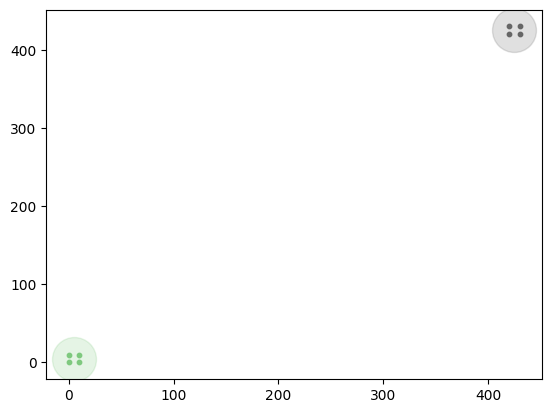

In [109]:
kmeans_birthday = KMeans(birthday_dataset, 2)
print(f'{kmeans_birthday.converged=}')
display_clusters(kmeans_birthday.clusters)

kmeans_blobs.converged=True


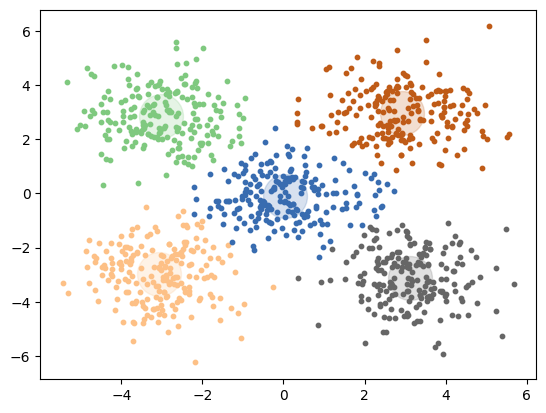

In [110]:
kmeans_blobs = KMeans(blobs_dataset, 5)
print(f'{kmeans_blobs.converged=}')
display_clusters(kmeans_blobs.clusters)

kmeans_circles.converged=True


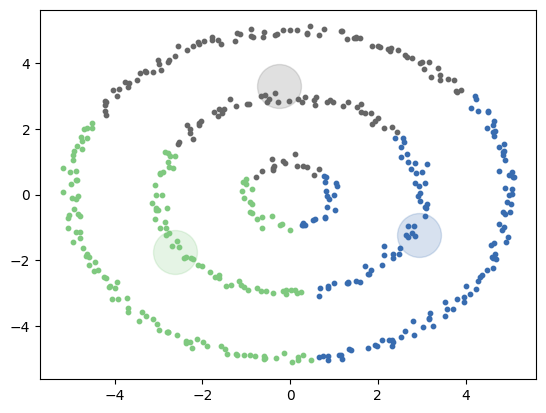

In [111]:
kmeans_circles = KMeans(circles_dataset, 3)
print(f'{kmeans_circles.converged=}')
display_clusters(kmeans_circles.clusters)

In [98]:
"""
Benchmark Compared to SKLearn
"""
import time
from sklearn.cluster import KMeans as SKMeans


num_times_to_run = 100

start_time = time.time()
for _ in range(num_times_to_run):
    kmeans_blobs = KMeans(blobs_dataset, 5)
    
end_time = time.time()
our_duration = (end_time - start_time) / num_times_to_run

print(f"Our implementation took {our_duration} seconds per KMeans cluster fit")

X = np.array([list(t) for t in blobs_dataset])
start_time = time.time()
for _ in range(num_times_to_run):
    kmeans = SKMeans(n_clusters=5)
    kmeans.fit(X)

end_time = time.time()
their_duration = (end_time - start_time) / num_times_to_run

print(f"SKLearn implementation took {duration} seconds per KMeans cluster fit")

print(f"Thus, the SKLearn implementation is {((our_duration)/their_duration)}x faster than ours")

Our implementation took 0.013907568454742432 seconds per KMeans cluster fit
SKLearn implementation took 0.010097181797027588 seconds per KMeans cluster fit
Thus, the SKLearn implementation is 1.2507559846776815x faster than ours
